<a href="https://colab.research.google.com/github/ahmadkhan242/PlayingWithMNIST/blob/main/task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip

In [ ]:
!unzip trainPart1.zip

## For this task I had used Pytorch library to implement CNN.

In [1]:
# Importing all libraries  required.
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import os,shutil,json
import glob
import torch.utils.data
import math
from skimage import io, transform
from PIL import Image
import torchvision as vision
from torchvision import transforms, datasets
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder

torch.cuda.empty_cache()

### The function below takes first ten folder from `train` folder and save it to `new_train` folder.

In [ ]:
root_dir = "/content/train"
all_filepaths = []
all_main_files = sorted(glob.glob(root_dir+'/*'))
for i in range(0, len(all_main_files[0:10])):
  
  all_files = sorted(glob.glob(all_main_files[i]+'/*.png'))
  for files in all_files:
      if not os.path.exists("/content/new_train/"  + str(i)):
          os.makedirs("/content/new_train/"  + str(i))
      os.rename(files, "/content/new_train/"  + str(i) +"/"+ files.split("/")[-1])

root_dir = "/content/new_train"

### The funtion below is used to create train and validation loader.

In [ ]:
def prepare_dataset(dataset_path):
  """ Function to create train and validation loader.
    Params:
        dataset_path: path where all images are.
    
    returns: 
        train_loader: train loader with batch size of 64
        validation_loader: validation loader with batch size of 128
        
    Note: Split ratio and batch sizes are pre-defined you can change it in this function.
    """

  labels = os.listdir(dataset_path)

  # Here images are resized and converted to grayscale so that we have data consistency for other tasks
  dataset = ImageFolder(
      dataset_path,
      transforms.Compose([transforms.Resize((32,32)),
                         transforms.ToTensor(),transforms.Grayscale(num_output_channels=1)])
  )
  # Validation split of 15%
  val_split = int(len(dataset)*0.15)
  train_split = len(dataset) - val_split

  train_dataset, val_dataset = random_split(dataset, [train_split, val_split])

  # to make sure the split is right.
  assert (len(train_dataset)+len(val_dataset)) == len(dataset)

  train_loader = torch.utils.data.DataLoader(train_dataset, 64, shuffle=True)
  validation_loader = torch.utils.data.DataLoader(val_dataset, 128) 

  return (train_loader, validation_loader)


In [ ]:
# executing prepare_dataset function
data_dir = '/content/new_train'
train_loader, validation_loader = prepare_dataset(data_dir)

### Data visualisation 

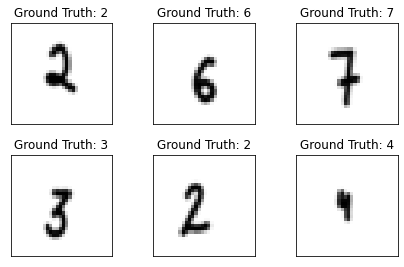

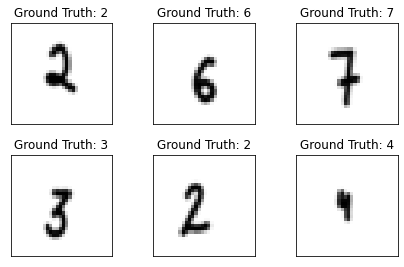

In [ ]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

### Here the CNN architecture  is defined, the architecture is of ResNet with four layers and one resedual block in each layer( See conclusion for detail).

In [2]:

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=(3,3), stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=(3,3), stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=(3,3), bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=(3,3), stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=(3,3), bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=(4,4), stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3,3), stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=1)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=1)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=1)
        self.linear1 = nn.Linear(512, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, num_classes)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.4)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 5)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 5)
        out = torch.flatten(out, 1)
        out = self.linear1(out)
        out = self.dropout1(out)
        out = self.linear2(out)
        out = self.dropout2(out)
        out = self.linear3(out)
        return out


### In the cell below, defined the Model, the loss function, and the Optimizer I have used for this task. 

In [3]:
model = ResNet(BasicBlock, [1, 1, 1, 1])

criterion = nn.CrossEntropyLoss()
torch.cuda.empty_cache()

if torch.cuda.is_available():
	print(torch.cuda.get_device_name(0))
	model = model.cuda()
	optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
	criterion = criterion.cuda()

Tesla P100-PCIE-16GB


### Here the train function is defined for training the model defined above.
### Please follow the comment to guide your self in the train function.

In [ ]:
# Loss and accuracy list are defined, these lists are used for graph.
train_loss_list = []
val_loss_list = []
epc_list = []
train_acc_list = []
val_acc_list = []

def train():
  # best_valid_loss is defined so as to save the best validation loss which is lowest one.
  best_valid_loss = float('Inf')

  print("Training Started !!!")
  for i in range(50):
    training_loss = 0
    tcorrect = 0
    ttotal = 0
    model.train()
    for features, labels in train_loader:
      # Label and features assigning
      features, labels = Variable(features.cuda()), Variable(labels.cuda())
      optimizer.zero_grad()

      # Output collection from model
      outputs = model(features.float())
      
      # Loss calculation and updation
      losss = criterion(outputs.cuda(), labels.type(torch.LongTensor).cuda())
      losss.backward()
      optimizer.step()
      training_loss += losss.item()

      # Prediction
      _, pred = torch.max(outputs, 1)
      ttotal+= labels.reshape(-1).size(0)
      tcorrect+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
  
    # Validation step starts from here.
    validation_loss = 0
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
      for features, labels in validation_loader:
        # Label and features assigning
        features, labels = Variable(features.cuda()), Variable(labels.cuda())

        # Output collection from model
        outputs = model(features.float())
        
        # Loss calculation, here we skip the backward and 
        # optimizer step as we do not update weights while validating a model
        loss = criterion(outputs.cuda(), labels.type(torch.LongTensor).cuda())

        # Prediction
        _, pred = torch.max(outputs, 1)
        total+= labels.reshape(-1).size(0)
        correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
        validation_loss += loss.item()


    train_loss_list.append(training_loss/len(train_loader))
    val_loss_list.append(validation_loss/len(validation_loader))
    epc_list.append(i)
    train_acc_list.append(100*(tcorrect/ttotal))
    val_acc_list.append(100*(correct/total))

    # Logic was defined so as to save the weights of model when validation loss is lowest.
    if best_valid_loss > validation_loss:
        best_valid_loss = validation_loss 
        # Saving Best Pre-Trained Model as .pth file
        torch.save(model.state_dict(), "task2.pth")
        
    print("Epoch {} - \nTraning loss: {}".format(i+1, training_loss/len(train_loader)))
    print("Validation loss: {}".format( validation_loss/len(validation_loader)))
    print("Trainig Accuracy: {}".format( 100*(tcorrect/ttotal)))
    print("Validation Accuracy: {}".format(100*(correct/total)))

train()
print("Training Complete")

Training Started !!!
Epoch 1 - 
Traning loss: 2.0703628063201904
Validation loss: 2.7540347576141357
Trainig Accuracy: 23.52941176470588
Validation Accuracy: 11.666666666666666
Epoch 2 - 
Traning loss: 1.6184162334962324
Validation loss: 3.920053243637085
Trainig Accuracy: 40.588235294117645
Validation Accuracy: 13.333333333333334
Epoch 3 - 
Traning loss: 1.2030069015242837
Validation loss: 5.686151027679443
Trainig Accuracy: 56.470588235294116
Validation Accuracy: 11.666666666666666
Epoch 4 - 
Traning loss: 0.8871240561658685
Validation loss: 2.874668598175049
Trainig Accuracy: 68.52941176470588
Validation Accuracy: 30.0
Epoch 5 - 
Traning loss: 0.5695564421740446
Validation loss: 0.7450859546661377
Trainig Accuracy: 80.88235294117648
Validation Accuracy: 78.33333333333333
Epoch 6 - 
Traning loss: 0.4338908777995543
Validation loss: 9.816723823547363
Trainig Accuracy: 82.6470588235294
Validation Accuracy: 16.666666666666664
Epoch 7 - 
Traning loss: 0.37899772551926697
Validation loss:

### Graph plot of training loss and validation loss with no of epochs.


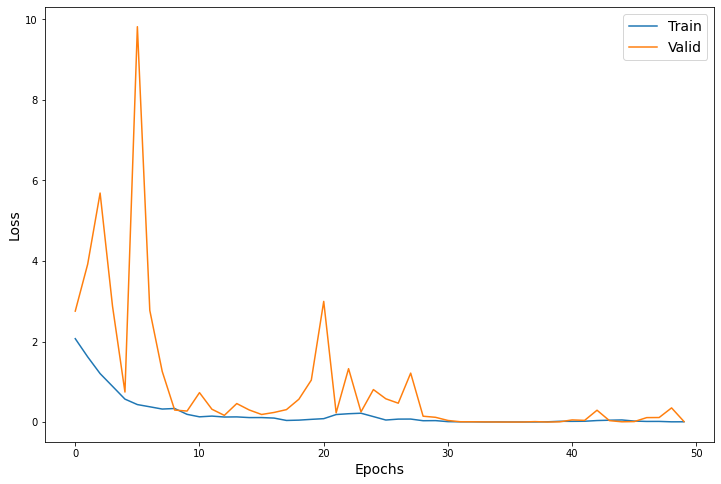

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(epc_list, train_loss_list, label='Train')
plt.plot(epc_list, val_loss_list, label='Valid')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Graph plot of training accuracy and validation accuracy with no of epochs.


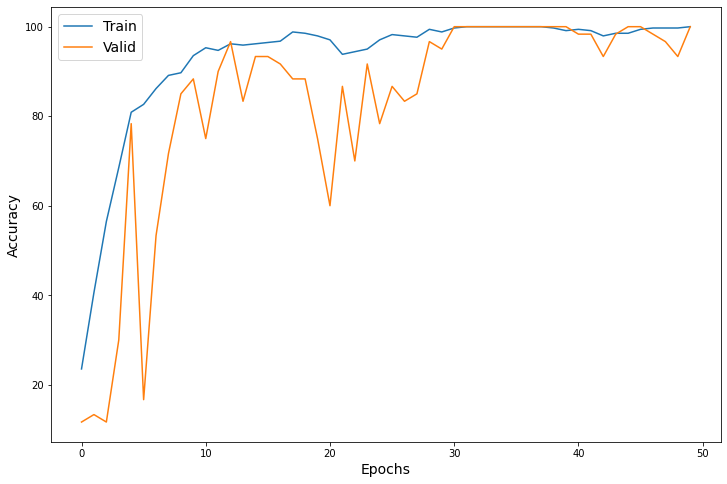

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(epc_list, train_acc_list, label='Train')
plt.plot(epc_list, val_acc_list, label='Valid')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=14)
plt.show()

# MNIST training part.

### Downloading MNIST dataset from pytorch datasets API.

In [5]:
# Images were tranformed to tensor and resized to 32x32
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((32, 32))
        ])

# Load and transform data
trainset = datasets.MNIST('/mnist', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)

testset = datasets.MNIST('/mnist', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)


Extracting /mnist/MNIST/raw/train-images-idx3-ubyte.gz to /mnist/MNIST/raw




Extracting /mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /mnist/MNIST/raw




Extracting /mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /mnist/MNIST/raw




Extracting /mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /mnist/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Data visualisation 

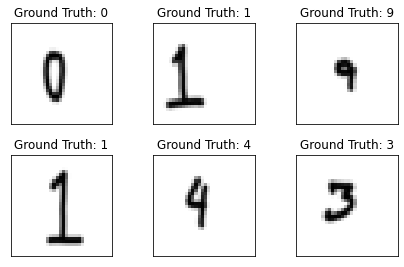

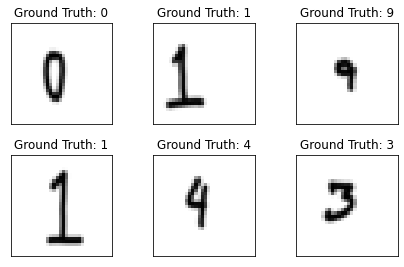

In [ ]:
examples = enumerate(validation_loader)
batch_idx, (example_data, example_targets) = next(examples)
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

### In the cell below, defined the Model, the loss function, and the Optimizer I have used for this task. 
### Same architecture is used to maintain  consistency .

In [ ]:
mnist_model = ResNet(BasicBlock, [1, 1, 1, 1])
criterion = nn.CrossEntropyLoss()
torch.cuda.empty_cache()

if torch.cuda.is_available():
	print(torch.cuda.get_device_name(0))
	mnist_model = mnist_model.cuda()
	optimizer = optim.Adam(mnist_model.parameters(), lr=1e-3, weight_decay=1e-4)
	criterion = criterion.cuda()

Tesla P100-PCIE-16GB


In [6]:
%%time
# Loss and accuracy list are defined, these lists are used for graph.
train_loss_list = []
val_loss_list = []
epc_list = []
train_acc_list = []
val_acc_list = []

def train():
  # best_valid_loss is defined so as to save the best validation loss which is lowest one.
  best_valid_loss = float('Inf')

  print("Training Started !!!")
  for i in range(25):
    training_loss = 0
    tcorrect = 0
    ttotal = 0
    mnist_model.train()
    for features, labels in trainloader:
      # Label and features assigning
      features, labels = Variable(features.cuda()), Variable(labels.cuda())
      optimizer.zero_grad()

      # Output collection from mnist_model
      outputs = mnist_model(features.float())
      
      # Loss calculation and updation
      losss = criterion(outputs.cuda(), labels.type(torch.LongTensor).cuda())
      losss.backward()
      optimizer.step()
      training_loss += losss.item()

      # Prediction
      _, pred = torch.max(outputs, 1)
      ttotal+= labels.reshape(-1).size(0)
      tcorrect+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
  
    # Validation step starts from here.
    validation_loss = 0
    correct = 0
    total = 0
    mnist_model.eval()
    with torch.no_grad():
      for features, labels in testloader:
        # Label and features assigning
        features, labels = Variable(features.cuda()), Variable(labels.cuda())

        # Output collection from mnist_model
        outputs = mnist_model(features.float())
        
        # Loss calculation, here we skip the backward and 
        # optimizer step as we do not update weights while validating a mnist_model
        loss = criterion(outputs.cuda(), labels.type(torch.LongTensor).cuda())

        # Prediction
        _, pred = torch.max(outputs, 1)
        total+= labels.reshape(-1).size(0)
        correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
        validation_loss += loss.item()


    train_loss_list.append(training_loss/len(trainloader))
    val_loss_list.append(validation_loss/len(testloader))
    epc_list.append(i)
    train_acc_list.append(100*(tcorrect/ttotal))
    val_acc_list.append(100*(correct/total))

    # Logic was defined so as to save the weights of model when validation loss is lowest.
    if best_valid_loss > validation_loss:
        best_valid_loss = validation_loss 
        # Saving Best Pre-Trained Model as .pth file
        torch.save(model, "mnist_task2.pth")
        
    print("Epoch {} - \nTraning loss: {}".format(i+1, training_loss/len(trainloader)))
    print("Validation loss: {}".format( validation_loss/len(testloader)))
    print("Trainig Accuracy: {}".format( 100*(tcorrect/ttotal)))
    print("Validation Accuracy: {}".format(100*(correct/total)))

train()

print("Training Complete")

Training Started !!!
Epoch 1 - 
Traning loss: 0.153887165337379
Validation loss: 0.06581557172945925
Trainig Accuracy: 95.17999999999999
Validation Accuracy: 97.89
Epoch 2 - 
Traning loss: 0.05674685371805356
Validation loss: 0.02680712928610509
Trainig Accuracy: 98.34333333333333
Validation Accuracy: 99.11
Epoch 3 - 
Traning loss: 0.044938789969528596
Validation loss: 0.03992969378655116
Trainig Accuracy: 98.67166666666667
Validation Accuracy: 98.64
Epoch 4 - 
Traning loss: 0.03985383930790579
Validation loss: 0.0670761238191206
Trainig Accuracy: 98.84333333333333
Validation Accuracy: 97.86
Epoch 5 - 
Traning loss: 0.038103328927964676
Validation loss: 0.030919206365438243
Trainig Accuracy: 98.87
Validation Accuracy: 99.07000000000001
Epoch 6 - 
Traning loss: 0.036600632526574715
Validation loss: 0.04400538129358452
Trainig Accuracy: 98.99833333333333
Validation Accuracy: 98.72
Epoch 7 - 
Traning loss: 0.03266581264037482
Validation loss: 0.044726684964166166
Trainig Accuracy: 99.015


### Graph plot of training loss and validation loss with no of epochs.

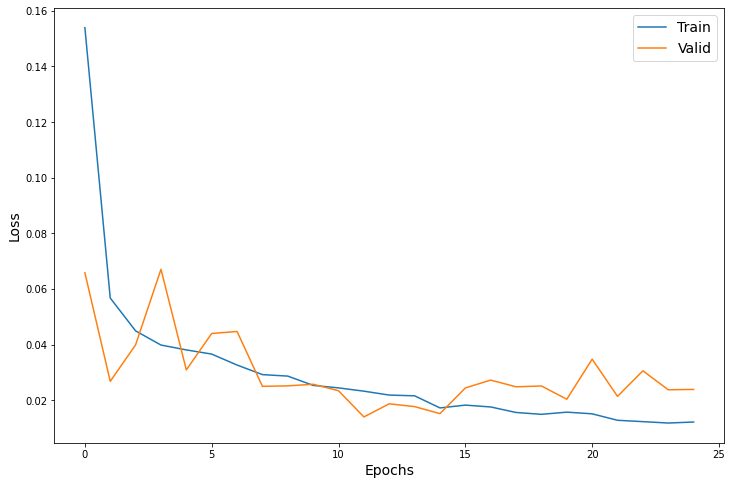

In [7]:
plt.figure(figsize=(12, 8))
plt.plot(range(0, 25), train_loss_list, label='Train')
plt.plot(range(0, 25), val_loss_list, label='Valid')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Graph plot of training accuracy and validation accuracy with no of epochs.

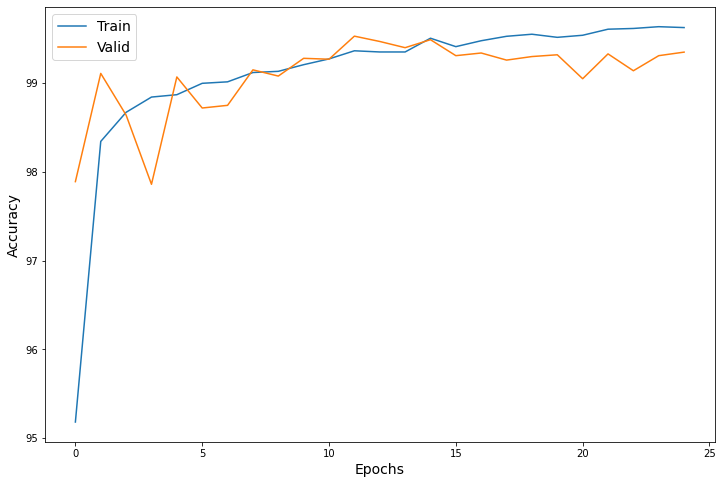

In [8]:
plt.figure(figsize=(12, 8))
plt.plot(range(0, 25), train_acc_list, label='Train')
plt.plot(range(0, 25), val_acc_list, label='Valid')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=14)
plt.show()

# Now training MNIST dataset using pre-trained weights of model we trained using first 10 labels from the given dataset

In [ ]:
model =  ResNet(BasicBlock, [1, 1, 1, 1])
pre_trained = torch.load("task2.pth")
 
model.load_state_dict(pre_trained, strict=False)
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128,

### In the cell below, defined the Model, the loss function, and the Optimizer I have used for this task. 

In [ ]:
model = model
criterion = nn.CrossEntropyLoss()
torch.cuda.empty_cache()

if torch.cuda.is_available():
	print(torch.cuda.get_device_name(0))
	model = model.cuda()
	optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
	criterion = criterion.cuda()

Tesla P100-PCIE-16GB


In [9]:
%%time
# Loss and accuracy list are defined, these lists are used for graph.
train_loss_list = []
val_loss_list = []
epc_list = []
train_acc_list = []
val_acc_list = []

def train():
  # best_valid_loss is defined so as to save the best validation loss which is lowest one.
  best_valid_loss = float('Inf')

  print("Training Started !!!")
  for i in range(25):
    training_loss = 0
    tcorrect = 0
    ttotal = 0
    model.train()
    for features, labels in trainloader:
      # Label and features assigning
      features, labels = Variable(features.cuda()), Variable(labels.cuda())
      optimizer.zero_grad()

      # Output collection from model
      outputs = model(features.float())
      
      # Loss calculation and updation
      losss = criterion(outputs.cuda(), labels.type(torch.LongTensor).cuda())
      losss.backward()
      optimizer.step()
      training_loss += losss.item()

      # Prediction
      _, pred = torch.max(outputs, 1)
      ttotal+= labels.reshape(-1).size(0)
      tcorrect+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
  
    # Validation step starts from here.
    validation_loss = 0
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
      for features, labels in testloader:
        # Label and features assigning
        features, labels = Variable(features.cuda()), Variable(labels.cuda())

        # Output collection from model
        outputs = model(features.float())
        
        # Loss calculation, here we skip the backward and 
        # optimizer step as we do not update weights while validating a model
        loss = criterion(outputs.cuda(), labels.type(torch.LongTensor).cuda())

        # Prediction
        _, pred = torch.max(outputs, 1)
        total+= labels.reshape(-1).size(0)
        correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
        validation_loss += loss.item()


    train_loss_list.append(training_loss/len(trainloader))
    val_loss_list.append(validation_loss/len(testloader))
    epc_list.append(i)
    train_acc_list.append(100*(tcorrect/ttotal))
    val_acc_list.append(100*(correct/total))

    # Logic was defined so as to save the weights of mnist_model when validation loss is lowest.
    if best_valid_loss > validation_loss:
        best_valid_loss = validation_loss 
        # Saving Best Pre-Trained Model as .pth file
        torch.save(model, "mnist_pre_task2.pth")
        
    print("Epoch {} - \nTraning loss: {}".format(i+1, training_loss/len(trainloader)))
    print("Validation loss: {}".format( validation_loss/len(testloader)))
    print("Trainig Accuracy: {}".format( 100*(tcorrect/ttotal)))
    print("Validation Accuracy: {}".format(100*(correct/total)))

train()

print("Training Complete")

Training Started !!!
Epoch 1 - 
Traning loss: 0.011410425078529463
Validation loss: 0.021088420520703074
Trainig Accuracy: 99.62333333333333
Validation Accuracy: 99.38
Epoch 2 - 
Traning loss: 0.0113828953917347
Validation loss: 0.02502193233055861
Trainig Accuracy: 99.66166666666668
Validation Accuracy: 99.31
Epoch 3 - 
Traning loss: 0.010807465460588134
Validation loss: 0.024942003102394295
Trainig Accuracy: 99.68833333333333
Validation Accuracy: 99.29
Epoch 4 - 
Traning loss: 0.009727113317594975
Validation loss: 0.024397923046101052
Trainig Accuracy: 99.73833333333333
Validation Accuracy: 99.33999999999999
Epoch 5 - 
Traning loss: 0.010824851085628523
Validation loss: 0.022843317590090746
Trainig Accuracy: 99.65166666666667
Validation Accuracy: 99.38
Epoch 6 - 
Traning loss: 0.00964255584841482
Validation loss: 0.0246457019891324
Trainig Accuracy: 99.71833333333333
Validation Accuracy: 99.33
Epoch 7 - 
Traning loss: 0.0094632355110202
Validation loss: 0.016579224548186635
Trainig A

### Graph plot of training loss and validation loss with no of epochs.

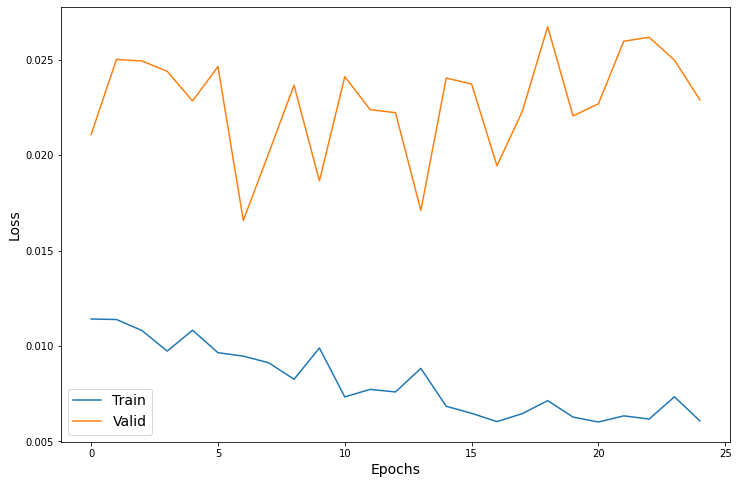

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(range(0, 25), train_loss_list, label='Train')
plt.plot(range(0, 25), val_loss_list, label='Valid')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

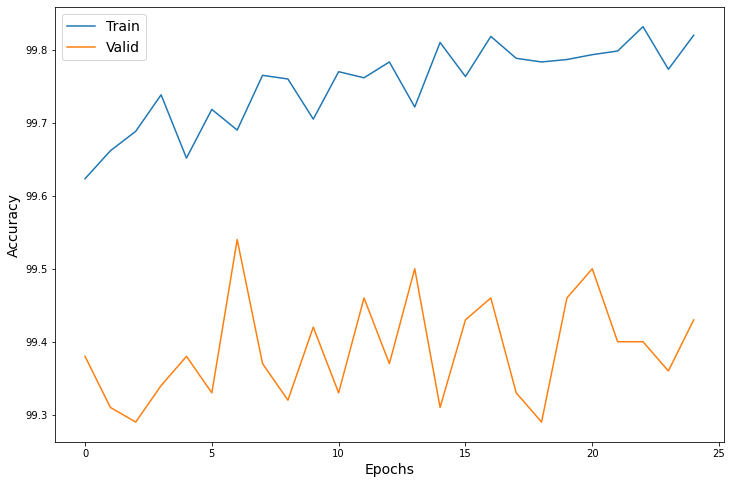

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(range(0, 25), train_acc_list, label='Train')
plt.plot(range(0, 25), val_acc_list, label='Valid')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=14)
plt.show()

# Conclusion  - 
###  `Dataset` -   
* `Dataset information`  - 
  * `Part 1` custom dataset 
    * No of classes - 10
    * No of samples each - 40 
    * Total samples - 400
  * `Part 2` MNIST dataset
    * No of classes - 10
    * Training samples - 60,000 
    * Testing sample - 10,000 

  * `Validation split` of 15% was used for part 1.  
  * `Pre-Processing`  
    * Images were resized to 32x32 to reduce computational power.
    * Images were converted to grayscale(single channel) so that we have data consistency for other tasks.  

### `Model` - 
* For both part 1 and part 2, same Resnet architechture is used.
* Resnet architecture with 4 layers and 1 resudual block in each layer, and finally three linear layers where used with dropout in first linear layer and second linear layer.

  <details> 
    <summary>Complete Architecture summary</summary>
    
  ```bash
        ----------------------------------------------------------------
                Layer (type)               Output Shape         Param #
        ================================================================
                    Conv2d-1           [-1, 64, 32, 32]             576
              BatchNorm2d-2           [-1, 64, 32, 32]             128
                    Conv2d-3           [-1, 64, 32, 32]          36,864
              BatchNorm2d-4           [-1, 64, 32, 32]             128
                    Conv2d-5           [-1, 64, 32, 32]          36,864
              BatchNorm2d-6           [-1, 64, 32, 32]             128
                BasicBlock-7           [-1, 64, 32, 32]               0
                    Conv2d-8          [-1, 128, 32, 32]          73,728
              BatchNorm2d-9          [-1, 128, 32, 32]             256
                  Conv2d-10          [-1, 128, 32, 32]         147,456
              BatchNorm2d-11          [-1, 128, 32, 32]             256
                  Conv2d-12          [-1, 128, 32, 32]           8,192
              BatchNorm2d-13          [-1, 128, 32, 32]             256
              BasicBlock-14          [-1, 128, 32, 32]               0
                  Conv2d-15          [-1, 256, 32, 32]         294,912
              BatchNorm2d-16          [-1, 256, 32, 32]             512
                  Conv2d-17          [-1, 256, 32, 32]         589,824
              BatchNorm2d-18          [-1, 256, 32, 32]             512
                  Conv2d-19          [-1, 256, 32, 32]          32,768
              BatchNorm2d-20          [-1, 256, 32, 32]             512
              BasicBlock-21          [-1, 256, 32, 32]               0
                  Conv2d-22            [-1, 512, 6, 6]       1,179,648
              BatchNorm2d-23            [-1, 512, 6, 6]           1,024
                  Conv2d-24            [-1, 512, 6, 6]       2,359,296
              BatchNorm2d-25            [-1, 512, 6, 6]           1,024
                  Conv2d-26            [-1, 512, 6, 6]         131,072
              BatchNorm2d-27            [-1, 512, 6, 6]           1,024
              BasicBlock-28            [-1, 512, 6, 6]               0
                  Linear-29                  [-1, 256]         131,328
                  Dropout-30                  [-1, 256]               0
                  Linear-31                  [-1, 128]          32,896
                  Dropout-32                  [-1, 128]               0
                  Linear-33                   [-1, 10]           1,290
        ================================================================
        Total params: 5,062,474
        Trainable params: 5,062,474
        Non-trainable params: 0
        ----------------------------------------------------------------
        Input size (MB): 0.00
        Forward/backward pass size (MB): 25.49
        Params size (MB): 19.31
        Estimated Total Size (MB): 44.81
        ----------------------------------------------------------------

  ```
</details> 

### `Training Methodology` -
  * Epoch = 25     
  * Learning rate - 0.001.
  * weight decay - 0.0001.
  * Training batch size = 64
  * Validation batch size = 128
  * Batch Normalisation and Dropout of 0.3 and 0.4 where used.  

### `Results` - 
  * `Part 1`
    * Max Training accuracy - 100
    * Max Validation accuracy - 100
  * `Part 2`
    * `Using pre-trained weights`
      * Max Training accuracy - 99.83
      * Max Validation accuracy - 99.5
      * Min Training loss - 0.0061
      * Min Validation loss - 0.0223
    * `Using random weights`
      * Max Training accuracy - 99.62
      * Max Validation accuracy - 99.53
      * Min Training loss: 0.0121
      * Min Validation loss: 0.0239

### `Report` -
  * Motive of this task was to analyse the convergence of the model using MNIST dataset when we initialize weights randomly and when we use pretrained weights.
  * From the above results, It is clear the model initialized with pre-trained weights, converge slightly better than the model initialized with random weights.
  * The model initialized with pre-trained weights
    * Loss in first epoch - `0.0114` (training), `0.0210` (validation)
    * Loss in last epoch - `0.0060` (training), `0.0229` (validation)
  * The model initialized with random weights(inbuit in pytorch)
    * Loss in first epoch - `0.1538` (training), 0.0658(validation)
    * Loss in last epoch - `0.0121` (training), `0.0239` (validation)
  * Both model took nearly equal time to converge

### `Refrence`
  * https://github.com/pytorch/vision